# Soccer Analysis - Portuguese League example

Manu people watch soccer games, however, it is never clear which part is the result of a team's merit or just a fruit of chance.

Questions like: 

* What is the probability of a team winning against another?
* In which position would a Portuguese team be if it played in another league?
* What is the chance of a team winning the league?

May have an answer through mathematical analysis.

I addressed these and other questions, through statistical modeling.
A statistical model is a class of mathematical model that embodies several assumptions, derived from the nature of the problem. Those assumptions will give rise to a family of statistical models, with unknown parameters, which will be determined to adjust to a training set.

Based on the probability distribution obtained it will be possible to make analysis of the likelihood of a given event to happen.

## Key Outputs
* **Descriptive Data Visualization** - sketch out the main figures of the season.
* **Statistical Modeling**
 * *The Model* - explain it
 * *Offensive and Defensive Score per Team*
 * *Advantage of playing at home* - Is it statistical significant?
 * *Rank and Pontuation at the end of the season distribution* - for example, it possible to measure the chances of a team winning the league

### 0.1 Data Extraction
We will extact data from the website http://www.football-data.co.uk/data.php that provides free Historical data of Portuguese Football League I

In [2]:
import pandas as pd
import numpy as np

# the last line is void, then the skipfooter=1 argument
df = pd.read_csv("http://www.football-data.co.uk/mmz4281/1516/P1.csv", engine='python', skipfooter=1)

Extracted data have the following form:

Rights columns with fractional values refers to oods data from several betting houses. For this analysis we will ignore them.

In [3]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,P1,14/08/15,Tondela,Sp Lisbon,1,2,A,0,1,A,...,1.77,24.0,1.50,2.02,1.94,1.95,1.89,15.00,5.83,1.27
1,P1,15/08/15,Belenenses,Rio Ave,3,3,D,1,1,D,...,1.52,23.0,0.00,1.80,1.73,2.20,2.10,2.29,3.11,3.74
2,P1,15/08/15,Porto,Guimaraes,3,0,H,1,0,H,...,2.17,24.0,-2.00,2.00,1.94,1.95,1.88,1.19,7.19,22.21
3,P1,16/08/15,Benfica,Estoril,4,0,H,0,0,D,...,2.06,25.0,-1.25,1.75,1.69,2.28,2.15,1.32,5.45,11.89
4,P1,16/08/15,Moreirense,Arouca,0,2,A,0,0,D,...,1.52,23.0,-0.25,2.00,1.94,1.94,1.88,2.32,3.34,3.37


### 0.2 Data Manipulation
Desired data format:
 * Round
 * Team1
 * Team2
 * Goals1 (Goals scored by Team1 / conceded by Team2)
 * Goals2 (Goals scored by Team2 / conceded by Team1)
 * Home (+1 if Team1 plays and home, -1 otherwise)


In [3]:
home = df[[2, 3, 4, 5]].copy() #selecting revelant columns
home.columns = ['Team1', 'Team2', 'Goals1', 'Goals2'] # renaming columns
home['Home'] = 1
away = df[[3,2,5,4]].copy()
away.columns = ['Team1', 'Team2', 'Goals1', 'Goals2']
away['Home'] = -1
matches = pd.concat([home, away]).sort_index() # we use sort_index to sort games by their order
matches['Round'] = matches.groupby('Team1').cumcount() + 1
matches = matches[['Round', 'Team1', 'Team2', 'Home', 'Goals1', 'Goals2']]  # reorder columns
# points that Team1 got in a given match
matches['Points'] = 3 * (matches['Goals1'] > matches['Goals2']) + (matches['Goals1'] == matches['Goals2'])
matches['Points'] = matches.groupby('Team1')['Points'].cumsum()
teams = matches[matches['Round'] == matches['Round'].max()].sort_values('Points', ascending=False)['Team1']

# 1 Data Visualization

## 1.1 Scored and Conceded Goals by Team

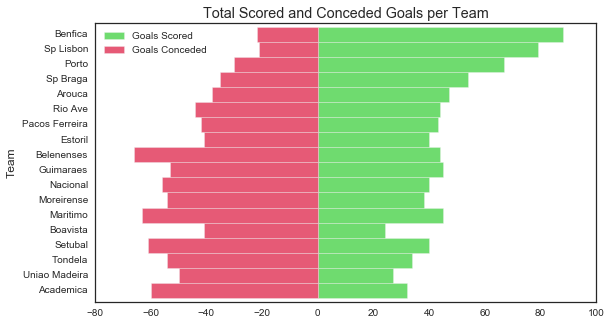

In [490]:
# importing visualization libraries
%matplotlib inline
from matplotlib import pyplot
import seaborn as sb

total_goals = matches.groupby('Team1')['Goals1', 'Goals2'].sum()
total_goals = total_goals.loc[teams][::-1]
total_goals.columns = ['Goals Scored', 'Goals Conceded']
total_goals['Goals Conceded'] *= -1

pyplot.style.use('seaborn-deep')
total_goals.plot.barh(figsize=(8,5), stacked=True, width=1.0, color=['limegreen', 'crimson'], alpha=.7)
pyplot.title("Total Scored and Conceded Goals per Team")
pyplot.ylabel("Team")

## 1.2 Points per Team over the Season

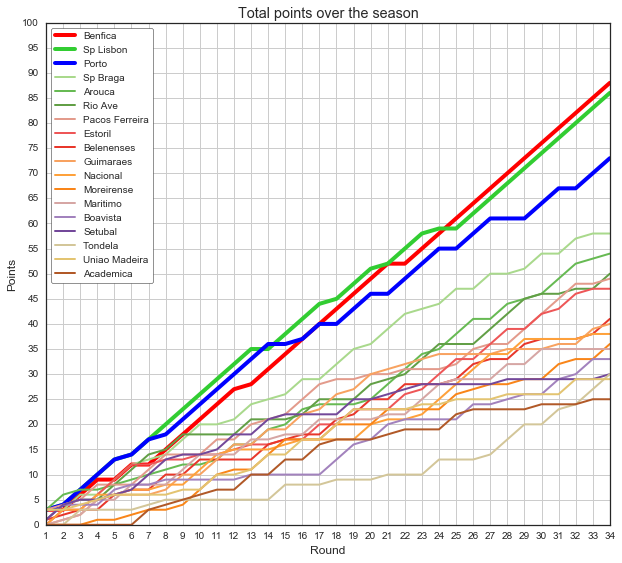

In [409]:
points = matches.set_index(['Round', 'Team1'])['Points'].unstack('Team1')[teams]

pyplot.style.use('seaborn-white')
ax = points.plot.line(lw=2, colormap='Paired', figsize=(9,9), style='-')
pyplot.ylabel("Points")
pyplot.xlabel("Round")
pyplot.title("Points per Team over the Season")
ax.lines[0].set_color('red')
ax.lines[1].set_color('limegreen')
ax.lines[2].set_color('blue')
ax.lines[0].set_linewidth(4)
ax.lines[1].set_linewidth(4)
ax.lines[2].set_linewidth(4)
pyplot.legend(loc='upper left', frameon=True)
pyplot.xticks(np.arange(2*17)+1)
pyplot.yticks(range(0,2*3*17,5))
pyplot.grid(True)

## 1.3 Goal Difference per Game

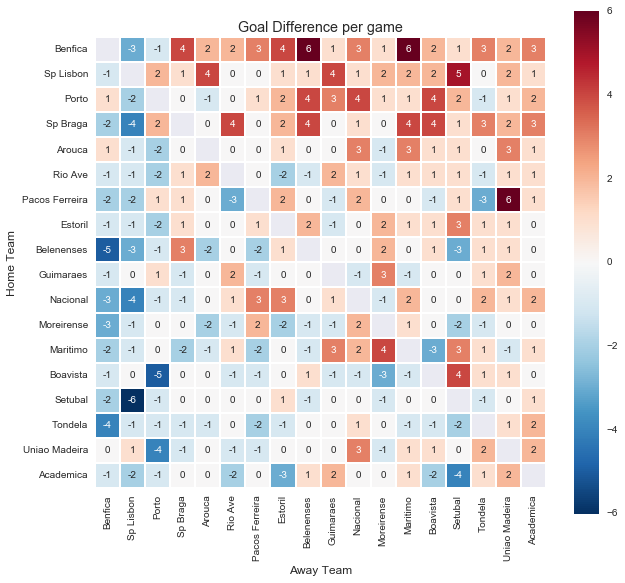

In [372]:
matches['diff'] = matches['Goals1'] - matches['Goals2']

data_map = matches[matches['Home']==1].set_index(['Team1', 'Team2'])['diff'].unstack(-1)
data_map = data_map.loc[teams][teams]  # reordering axis
pyplot.subplots(figsize=(9, 9))
pyplot.title("Goal Difference per game")
sb.heatmap(data_map, square=True, linewidths=1, annot=True, annot_kws={"size": 10})
pyplot.ylabel("Home Team")
pyplot.xlabel("Away Team")

# 2 Statistical Modeling

## 2.1 The Model

$$x_{ijk}\sim \mathrm{Poisson}\left(y_{ijk}\right)$$

$$ y_{ijk} = A(i)\cdot B(j)\cdot H(k)$$

$$A(i)=e^{a_i} \quad B(j) = e^{-b_j} \quad H(k)=e^{k\cdot h}$$

Since there is an invariance of results if we add a given value to all $a$'s and $b$'s equally, we force $A+B = 0$ where $A=\sum_i a_i$ and $B=\sum_i b_i$

Hence: $y_{ijk} = \exp{\left(a_i-b_j+k\cdot h\right)}$

We suppose that the goals that a team $i$ score against another team $j$ will depend on:
* The *atack score* of team $i$: $a_i$
* The *defensive score* of team $j$: $b_j$
* If the team $i$ plays at home ($k=1$) or not ($k=-1$)

## 2.2 Naive Approximation
To get a firt estimate for $a_i$, $b_j$ and $h$ parameters
$$\sum_{jk} y_{ijk} = \sum_{jk} \exp{\left(a_i-b_j+k\cdot h\right)}  \simeq  \sum_{jk} \exp{\left(a_i-\frac{\sum_j b_j}{N}\right)} $$
Using the following approximations: $e^h + e^{-h} \sim 2$ and $\sum_j \exp{b_j} \sim N \exp{\frac{\sum_j b_j}{N}}$

$e^{ a_i-b_j+k\cdot h} = y_{ijk}$

$\frac{1}{2(N-1)}\sum_{k}\sum_{j\neq i} x_{ijk} \simeq \frac{1}{2(N-1)}\sum_{k}\sum_{j\neq i} e^{ a_i-b_j+k\cdot h} \simeq \frac{1}{N-1}\sum_{j\neq i} e^{ a_i-b_j} \simeq e^{a_i - \frac{1}{N-1}(B - b_i)}$

Then, summing accross all $i$'s:

$\bar x = \frac{1}{2N(N-1)}\sum_{k}\sum_i\sum_{j\neq i} x_{ijk} ~ \frac{1}{N} \sum_i e^{a_i - \frac{1}{N-1}(B - b_i)} \simeq e^{\frac{1}{N}A - \frac{1}{N-1}B + \frac{1}{N(N-1)}B} = e^{\frac{2}{N}A}$

Hence, $\bar a \simeq \frac{1}{2} \ln \bar x$


$a_i + \frac{1}{N-1}b_i \simeq \ln \bar x_i - \frac{N}{2(N-1)} \ln \bar x$

$b_i + \frac{1}{N-1}a_i \simeq \frac{N}{2(N-1)} \ln \bar x - \ln \bar x_{\_i}$

$a_i \simeq \frac{(N-1)^2}{N(N-2)}\ln \bar x_i + \frac{N-1}{N(N-2)} \ln \bar x_{\_i} - \frac{N}{2(N-2)}\ln \bar x$

$b_i \simeq  \frac{N}{2(N-2)}\ln \bar x - \frac{N-1}{N(N-2)} \ln \bar x_{\_i} - \frac{(N-1)^2}{N(N-2)} \ln \bar x_{i}$

In [491]:
# initial guess
a = matches.groupby('Team1')['Goals1'].mean().map(np.log) - np.log(matches['Goals1'].mean())/2
b = np.log(matches['Goals2'].mean())/2 - matches.groupby('Team1')['Goals2'].mean().map(np.log)
xi_ = matches.groupby('Team1')['Goals1'].mean().map(np.log)
x_i = matches.groupby('Team1')['Goals2'].mean().map(np.log)
x_ = np.log(matches['Goals1'].mean())
n = teams.size
a = (((n-1)**2)/float(n*(n-2)) * xi_ + ((n-1)/float(n*(n-2))) * x_i - n/float(2*(n-2)) * x_)
b = -(((n-1)**2)/float(n*(n-2)) * x_i + ((n-1)/float(n*(n-2))) * xi_ - n/float(2*(n-2)) * x_)
h = matches.groupby('Home')['Goals1'].sum().map(np.log).reset_index().prod(1).sum()/2

score = pd.DataFrame({'a':a, 'b':b}, index=teams) # naive-score
print score

                       a         b
Team1                             
Benfica         0.756515  0.552763
Sp Lisbon       0.645506  0.605813
Porto           0.501232  0.257625
Sp Braga        0.293874  0.115672
Arouca          0.159409  0.041343
Rio Ave         0.101876 -0.101876
Pacos Ferreira  0.076061 -0.053838
Estoril         0.002067 -0.025387
Belenenses      0.125810 -0.508749
Guimaraes       0.135412 -0.289951
Nacional        0.020470 -0.338250
Moreirense     -0.033148 -0.298728
Maritimo        0.145615 -0.463394
Boavista       -0.510533  0.004766
Setubal         0.025518 -0.424069
Tondela        -0.144760 -0.292163
Uniao Madeira  -0.380627 -0.201327
Academica      -0.199376 -0.394310


## 2.3 Maximum Likelihood Estimation
Likelihood function:
$$l\left(a,b,h\right)=\sum_{ijk} x_{ijk} \ln y_{ijk} - y_{ijk}$$

## 2.4 Maxlike module
I use the maxlike module, that accepts several arguments, with different dimensions

In [14]:
# load maxlike module
import sys
sys.path.insert(0, 'C:\\Users\\laptop\\GitHub\\maxlike')
import maxlike

Besides the model, maxlike module needs the gradient and the hessian of the likelihood function as inputs.

* Gradient Calculation:
$$\frac{\partial l}{\partial a_i} = \sum_{jk} (x_{ijk} - y_{ijk})
\quad\quad
\frac{\partial l}{\partial b_j} = - \sum_{ik} (x_{ijk} - y_{ijk})
\quad\quad
\frac{\partial l}{\partial h} = \sum_{ijk} k\cdot(x_{ijk} - y_{ijk})$$

* Hessian Calculation:
$$\frac{\partial^2 l}{\partial a_i \partial a_j} = - \delta_{ij} \sum_{uk} y_{iuk}
\quad\quad
\frac{\partial^2 l}{\partial a_i \partial b_j} = \sum_{k} y_{ijk}
\quad\quad
\frac{\partial^2 l}{\partial a_i \partial h} = - \sum_{jk} k\cdot y_{ijk}$$
$$\frac{\partial^2 l}{\partial b_i \partial b_j} = - \delta_{ij} \sum_{uk} y_{ujk}
\quad\quad
\frac{\partial^2 l}{\partial b_j \partial h} = - \sum_{uk} y_{ujk}
\quad\quad
\frac{\partial^2 l}{\partial^2 h} = - \sum_{ijk} k^2\cdot y_{iuk}$$

In [225]:
_ = np.newaxis

def Y(I, coef):
    return I * np.exp(coef[0][:,_,_] - coef[1][_,:,_] + coef[2] * k[_,_,:])

def grad_L(I, X, Y, coef):
    D = X - Y
    return [
         D.sum((1,2)),
        -D.sum((0,2)),
        (D * k[_, _, :]).sum()]

def hess_L(I, X, Y, coef):
    return [
        [-np.diag(Y.sum((1,2)))],
        [Y.sum(2),
         -np.diag(Y.sum((0,2)))],
        [-(Y * k[_, _, :]).sum((1,2)),
          (Y * k[_, _, :]).sum((0,2)),
         -(Y * (k * k)[_, _, :]).sum()]]

def g(args):
    return args[0].sum() + args[1].sum()

def grad_g(args):
    return map(lambda x: np.ones(x.size), args)

def hess_g(args):
    return [[np.zeros((args[0].size, args[0].size))],
            [np.zeros((args[0].size, args[1].size)),
             np.zeros((args[1].size, args[1].size))]]

I, X, axis = maxlike.series_to_ndarray(matches.set_index(['Team1', 'Team2', 'Home']).Goals1)
t, t, k = axis
mle = maxlike.poisson(I, X)
mle.set_coef([score.loc[t,'a'], score.loc[t, 'b'].values, np.array(h)])
_ = np.newaxis
mle.set_model(Y)
mle.set_L(grad_L, hess_L)
mle.add_constraint([0,1], g, grad_g, hess_g)
mle.run(max_steps=1000, e=0.00001)
coef = mle.coef
score.loc[t,'a'] = coef[0]
score.loc[t,'b'] = coef[1]
h = coef[2]
score

0 0.802958436773


,a,b
Team1,,
Benfica,0.770551,0.540673
Sp Lisbon,0.661031,0.599068
Porto,0.507402,0.256814
Sp Braga,0.297420,0.118861
Arouca,0.161992,0.045295
Rio Ave,0.103474,-0.097931
Pacos Ferreira,0.077869,-0.049997
Estoril,0.004082,-0.022032
Belenenses,0.131995,-0.505016


## 2.5 Simulation

In [495]:
_ = np.newaxis
Y_test = np.exp(coef[0][:,_,_] - coef[1][_,:,_] + coef[2] * k[_,_,:])
N = 100000
X_test = np.random.poisson(np.multiply.outer(Y_test ,np.ones(N)))
X_test[np.arange(t.size), np.arange(t.size),:,:] = 0
# force the diagonal values to be zero - a team cannot play againts itself.
gd = X_test[:,:,1,:] - np.swapaxes(X_test[:,:,0,:],0,1)
points = (3.0*(gd>0) + 1.0*(gd==0)).sum(1) + (3.0*(gd<0) + 1.0*(gd==0)).sum(0)
pos = teams.size- points.argsort(0).argsort(0)

sim = pd.DataFrame(points.transpose(), index=range(N), columns=t)[teams]
pos = pd.DataFrame(pos.transpose(), index=range(N), columns=t)[teams]
sim_plot = pd.DataFrame(index=range(2*3*17))
pos_plot = pd.DataFrame(index=np.arange(teams.size)+1)
for team in teams.values:
    sim_plot[team] = (sim[team].values[:,None]==sim_plot.index.values[None,:]).sum(0)/float(N)
    pos_plot[team] = (pos[team].values[:,None]==pos_plot.index.values[None,:]).sum(0)/float(N)

### 2.5.1 Points Distribution Curve at the end of the Season

                    mean       std   25%   50%   75%
Benfica         84.93096  5.648282  81.0  85.0  89.0
Sp Lisbon       82.62985  5.883766  79.0  83.0  87.0
Porto           71.69653  6.646494  67.0  72.0  76.0
Sp Braga        61.45574  7.015380  57.0  61.0  66.0
Arouca          55.13746  7.124738  50.0  55.0  60.0
Rio Ave         49.48150  7.133810  45.0  49.0  54.0
Pacos Ferreira  49.97282  7.149952  45.0  50.0  55.0
Estoril         48.50097  7.105761  44.0  48.0  53.0
Belenenses      38.15486  6.941418  33.0  38.0  43.0
Guimaraes       45.13305  7.099939  40.0  45.0  50.0
Nacional        40.21961  6.976838  35.0  40.0  45.0
Moreirense      39.81295  6.955056  35.0  40.0  44.0
Maritimo        40.17281  7.003378  35.0  40.0  45.0
Boavista        35.83220  6.580320  31.0  36.0  40.0
Setubal         37.82923  6.923624  33.0  38.0  42.0
Tondela         36.93989  6.852330  32.0  37.0  42.0
Uniao Madeira   33.53085  6.573030  29.0  33.0  38.0
Academica       32.68716  6.588078  28.0  33.0

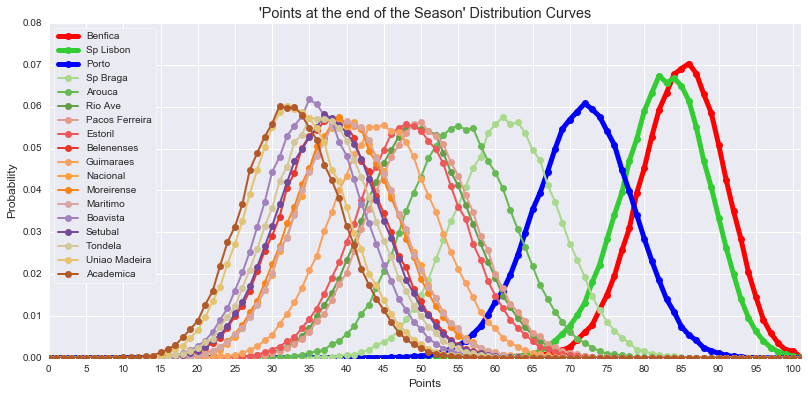

In [506]:
pyplot.style.use('seaborn-dark')
ax = sim_plot.plot.line(lw=2, colormap='Paired', figsize=(12,6), style='-o')
ax.lines[0].set_color('red')
ax.lines[1].set_color('limegreen')
ax.lines[2].set_color('blue')
ax.lines[0].set_linewidth(5)
ax.lines[1].set_linewidth(5)
ax.lines[2].set_linewidth(5)
pyplot.xticks(range(0,2*3*17,5))
pyplot.legend(loc='upper left', frameon=True)
pyplot.grid(True)
pyplot.title("'Points at the end of the Season' Distribution Curves")
pyplot.xlabel('Points')
pyplot.ylabel('Probability')
print sim.describe().loc[['mean', 'std', '25%', '50%', '75%']].transpose()

### 2.5.2 Rank Distribution Curve at the end of the Season

                    mean       std   25%   50%   75%
Benfica          1.48751  0.624890   1.0   1.0   2.0
Sp Lisbon        1.71905  0.661923   1.0   2.0   2.0
Porto            3.08187  0.817590   3.0   3.0   3.0
Sp Braga         4.55468  1.413991   4.0   4.0   5.0
Arouca           6.10095  2.134339   5.0   6.0   7.0
Rio Ave          7.95365  2.826429   6.0   7.0  10.0
Pacos Ferreira   7.81730  2.761858   6.0   7.0   9.0
Estoril          8.46030  2.922285   6.0   8.0  10.0
Belenenses      12.97147  3.251575  11.0  13.0  16.0
Guimaraes        9.85513  3.200869   7.0  10.0  12.0
Nacional        12.03004  3.344714   9.0  12.0  15.0
Moreirense      12.06150  3.391612   9.0  12.0  15.0
Maritimo        12.07242  3.309750  10.0  12.0  15.0
Boavista        14.05009  2.954446  12.0  15.0  16.0
Setubal         13.07926  3.323048  11.0  13.0  16.0
Tondela         13.52845  3.162488  11.0  14.0  16.0
Uniao Madeira   14.88145  2.868679  13.0  16.0  17.0
Academica       15.29488  2.745695  14.0  16.0

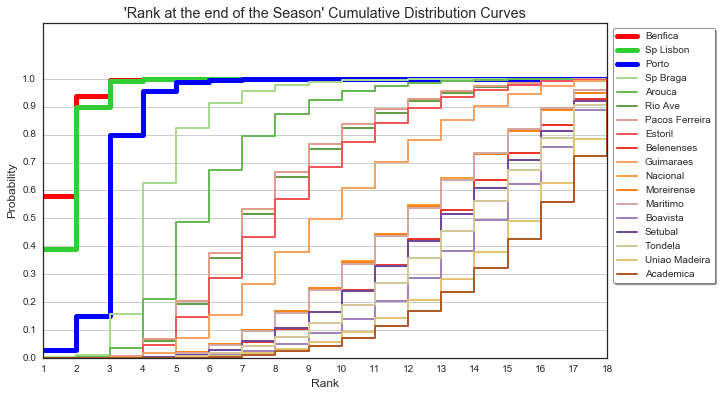

In [504]:
pyplot.style.use('seaborn-white')
ax = pos_plot.cumsum().plot.line(drawstyle="steps-post", lw=2, colormap='Paired', figsize=(9,6), style='-')
ax.lines[0].set_color('red')
ax.lines[1].set_color('limegreen')
ax.lines[2].set_color('blue')
ax.lines[0].set_linewidth(5)
ax.lines[1].set_linewidth(5)
ax.lines[2].set_linewidth(5)
legend = pyplot.legend(bbox_to_anchor=(1.2,1), ncol=1, frameon=True, shadow=True)
pyplot.xticks(np.arange(teams.size) + 1)
pyplot.yticks(np.arange(11)*.1)
pyplot.title("'Rank at the end of the Season' Cumulative Distribution Curves")
pyplot.xlabel('Rank')
pyplot.ylabel('Probability')
ax.yaxis.grid(True)
print pos.describe().loc[['mean', 'std', '25%', '50%', '75%']].transpose()


# 